In [78]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
loc_gdf=gpd.read_file('data/AQMS_loc.shp')

# Initialise

In [ ]:
# Read in all the data

AQMS_df=pd.read_csv('data/hourly.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')

cond=pd.read_csv('data/cond_hourly.csv')

In [ ]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)

In [ ]:
# Get all green spaces
Gsp=Gsp_gdf['geometry'].unary_union

# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [ ]:
# Set buffer zones for every road (50m)
Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)
# Get all road buffer zones
Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [ ]:
# Get all near-road green spaces
nRd_Gsp=Gsp.intersection(Rd_buffer)

In [ ]:
# Get all near-greenspace roads
nRd_Gsp_buffer=nRd_Gsp.buffer(50)
nGsp_Rd=Rd.intersection(nRd_Gsp_buffer)

In [ ]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [ ]:
# get all roads, green spaces, near-road green spaces and near-gsp roads in buffer zones around every sites
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
nGsp_Rd_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
    nGsp_Rd_shp.append(poly.intersection(nGsp_Rd))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp),len(nGsp_Rd_shp))

In [ ]:
# append them into the dataframe
loc_gdf['Rd']=Rd_shp
loc_gdf['Gsp']=Gsp_shp
loc_gdf['nRd_Gsp']=nRd_Gsp_shp
loc_gdf['nGsp_Rd']=nGsp_Rd_shp

# and set their data types to geometry
loc_gdf=loc_gdf.set_geometry('Rd').set_geometry('Gsp').set_geometry('nRd_Gsp').set_geometry('nGsp_Rd')

In [ ]:
# london boundary read in
london=gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['Gsp'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['nRd_Gsp'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Rd'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [ ]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [ ]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

In [ ]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [ ]:
# get the area of each buffer zone
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [ ]:
loc_gdf['Rd_len']=loc_gdf['Rd'].length

In [ ]:
# get percentages of green space and near-road green space areas 
loc_gdf['Gsp_area']=loc_gdf['Gsp'].area
loc_gdf['pct_nRd_Gsp']=loc_gdf['nRd_Gsp'].area/loc_gdf['Gsp_area']*100

In [ ]:
# near-road green space area per road length
loc_gdf['nRd_Gsp_per_Rd_len']=loc_gdf['nRd_Gsp'].area/loc_gdf['Rd_len']

In [ ]:
# percentage of near-green-space road
loc_gdf['pct_nGsp_Rd']=loc_gdf['nGsp_Rd'].length/loc_gdf['Rd_len']*100

In [ ]:
var_names=loc_gdf.columns[9:].values.tolist()

In [ ]:
# merge PM reading and site geogemetry data
df=pd.merge(AQMS_df,loc_gdf,left_on='Site',right_index=True)
df.info()

In [ ]:
# drop irrelevant columns
df.drop(['sitename','buffer_1km','Rd','Gsp','nRd_Gsp','nGsp_Rd','min_dis','buffer_area'],
        axis=1,inplace=True)
df.info()

In [ ]:
# covert the DateTime column to numpy.datetime variable
df['DateTime']=pd.to_datetime(df['DateTime'])

In [ ]:
# merge with conditional variables
cond['DateTime']=pd.to_datetime(cond['DateTime'])
df=df.merge(cond,on='DateTime')
df.info()

In [ ]:
df.hist()

In [ ]:
df['Gsp_area'].hist()

In [ ]:
df['log_Gsp_area']=np.log(df['Gsp_area'])
df['log_Gsp_area'].hist()

In [ ]:
df['nRd_Gsp_per_Rd_len'].hist()

In [ ]:
df['log_nRd_Gsp_per_Rd_len']=np.log(df['nRd_Gsp_per_Rd_len'])
df['log_nRd_Gsp_per_Rd_len'].hist()

In [ ]:
df[var_names].describe()

In [ ]:
# feature scaling
df['Rd_len']=df['Rd_len']/1000

In [ ]:
df.to_csv('temp_data.csv',index=False)

# Temporarily save

In [3]:
df=pd.read_csv('temp_data.csv')

In [4]:
df['DateTime']=pd.to_datetime(df['DateTime'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Site                    183960 non-null  object        
 1   Value                   183960 non-null  float64       
 2   DateTime                183960 non-null  datetime64[ns]
 3   geometry                183960 non-null  object        
 4   Rd_len                  183960 non-null  float64       
 5   Gsp_area                183960 non-null  float64       
 6   pct_nRd_Gsp             183960 non-null  float64       
 7   nRd_Gsp_per_Rd_len      183960 non-null  float64       
 8   pct_nGsp_Rd             183960 non-null  float64       
 9   bp_mean                 183960 non-null  float64       
 10  tmp_mean                183960 non-null  float64       
 11  rh_mean                 183960 non-null  float64       
 12  log_Gsp_area            183960

In [6]:
var_names=df.columns[4:9].tolist()

In [7]:
var_names[1]='log_Gsp_area'
var_names[3]='log_nRd_Gsp_per_Rd_len'
var_names

['Rd_len',
 'log_Gsp_area',
 'pct_nRd_Gsp',
 'log_nRd_Gsp_per_Rd_len',
 'pct_nGsp_Rd']

In [8]:
loc_gdf=pd.merge(df.groupby('Site').mean()[var_names],loc_gdf,left_index=True,right_on='siteid')

In [9]:
loc_gdf=loc_gdf.set_index('siteid')

In [10]:
# kernel weight matrix for the sites
weight=Kernel.from_dataframe(loc_gdf,geom_col='geometry',function='gaussian')

In [11]:
for var in var_names:
    moran_temp=Moran(loc_gdf[var].values,weight)
    print("Global Moran's I for "+var+' is '+str(round(moran_temp.I,5)))

Global Moran's I for Rd_len is 0.23493
Global Moran's I for log_Gsp_area is 0.12411
Global Moran's I for pct_nRd_Gsp is 0.11296
Global Moran's I for log_nRd_Gsp_per_Rd_len is 0.14754
Global Moran's I for pct_nGsp_Rd is 0.06421


<AxesSubplot:xlabel='hour'>

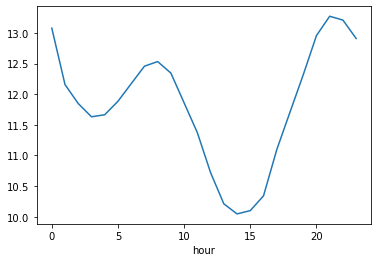

In [12]:
df['hour']=df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

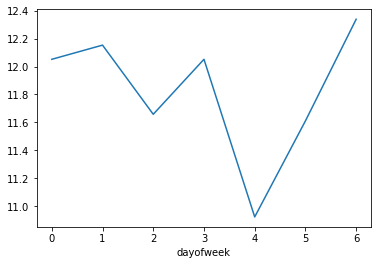

In [13]:
df['dayofweek']=df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

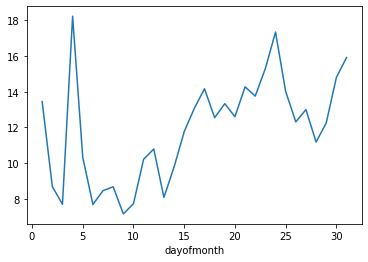

In [14]:
df['dayofmonth']=df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [17]:
def get_importance(reg, features, target, feature_names, rep=20):
    reg.fit(features, target)
    result={}
    importance = permutation_importance(reg, features, target, n_repeats=rep)
    for i, v in enumerate(importance.importances_mean):
        result[feature_names[i]] = round(v, 5)
    return result

In [101]:
def get_cv_score(reg, features, target, iter=100, split=10):
    reg.fit(features, target)
    r2=[]
    for i in range(iter):
        kf = KFold(n_splits=split, shuffle=True, random_state=i)
        cv = cross_val_score(reg, features, target, cv=kf).tolist()
        r2 = r2 + cv
    
    return ({'r2' : np.mean(r2), 'variance' : np.var(r2)})

In [19]:
reg = LinearRegression()
var = var_names + ['bp_mean', 'tmp_mean', 'rh_mean']

X = df[var].values
y = df['Value'].values

get_importance(reg, X, y, feature_names=var)

{'Rd_len': 0.00061,
 'log_Gsp_area': 0.00231,
 'pct_nRd_Gsp': 0.00979,
 'log_nRd_Gsp_per_Rd_len': 0.00187,
 'pct_nGsp_Rd': 0.0061,
 'bp_mean': 0.0825,
 'tmp_mean': 0.04135,
 'rh_mean': 0.00065}

In [23]:
get_cv_score(reg, X, y)

{'r2_cv': 0.06483,
 'tau_cv': 0.19098,
 'r2_var_cv': 1.1081033669121493e-09,
 'tau_var_cv': 1.784458613085053e-09}

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

reg.fit(X_train, y_train)
pred = reg.predict(X_test)

r = stats.pearsonr(y_test, pred)[0]
r2 = r**2
t,p_value = stats.kendalltau(y_test, pred)
print("r2 (obs): ", round(r2,5))   
print("tau (obs): ", round(t,5))

r2 (obs):  0.06625
tau (obs):  0.19314


In [105]:
h_fi = []
h_cv = []
h_coef = []
for hour in df['hour'].unique():
    X = df[df['hour']==hour].loc[:,var].values
    y = df[df['hour']==hour].loc[:,'Value'].values
    
    importance = list(get_importance(reg, X, y, feature_names=var).values())
    h_fi.append(importance)
    
    cv = list(get_cv_score(reg, X, y).values())
    h_cv.append(cv)
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    h_coef.append(coef)
    
var_col=['fi_' + elem for elem in var]
h_fi = pd.DataFrame(h_fi, columns=var_col)
h_cv = pd.DataFrame(h_cv, columns=['r2_cv', 'r2_var'])
h_coef = pd.DataFrame(h_coef, columns=var+['intercept'])

In [106]:
h_reg = pd.concat([h_coef, h_cv, h_fi], axis=1)
h_reg.head()

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_nRd_Gsp_per_Rd_len,pct_nGsp_Rd,bp_mean,tmp_mean,rh_mean,intercept,r2_cv,r2_var,fi_Rd_len,fi_log_Gsp_area,fi_pct_nRd_Gsp,fi_log_nRd_Gsp_per_Rd_len,fi_pct_nGsp_Rd,fi_bp_mean,fi_tmp_mean,fi_rh_mean
0,-0.400459,14.445871,0.376688,-12.842407,-0.247065,0.202783,-0.530646,0.116184,-359.161120,0.108095,0.000535,0.35144,2.23693,1.02325,1.32322,0.03863,0.08202,0.08080,0.01109
1,0.009116,-0.456809,0.013030,1.293369,-0.066925,0.196386,-0.483837,0.172304,-191.641636,0.095605,0.000433,0.00027,0.00257,0.00153,0.01477,0.00310,0.08526,0.07452,0.02490
2,-0.029306,0.990506,0.046972,-0.026651,-0.085198,0.192388,-0.484688,0.213033,-208.059063,0.097723,0.000408,0.00204,0.01116,0.01695,0.00001,0.00506,0.08063,0.06986,0.03578
3,-0.036879,1.270951,0.051805,-0.390410,-0.078414,0.182571,-0.479667,0.251145,-205.217170,0.098620,0.000816,0.00265,0.01621,0.01916,0.00134,0.00393,0.06490,0.06230,0.04239
4,0.009838,-0.377391,0.017509,1.249723,-0.076128,0.172279,-0.495817,0.286448,-179.577032,0.119112,0.000480,0.00027,0.00183,0.00280,0.01548,0.00433,0.07234,0.08182,0.06847


In [50]:
# set up a new column for month information
df['month']=df['DateTime'].dt.month

In [103]:
m_fi = []
m_cv = []
m_coef = []
for month in df['month'].unique():
    X = df[df['month']==month].loc[:, var].values
    y = df[df['month']==month].loc[:, 'Value'].values
    
    importance = list(get_importance(reg, X, y, feature_names=var).values())
    m_fi.append(importance)
    
    cv = list(get_cv_score(reg, X, y).values())
    m_cv.append(cv)
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    m_coef.append(coef)
    
m_fi = pd.DataFrame(m_fi, columns=var_col)
m_cv = pd.DataFrame(m_cv, columns=['r2', 'r2_var'])
m_coef = pd.DataFrame(m_coef, columns=var+['intercept'])

In [104]:
m_reg = pd.concat([m_coef, m_cv, m_fi], axis=1)
m_reg.head()

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_nRd_Gsp_per_Rd_len,pct_nGsp_Rd,bp_mean,tmp_mean,rh_mean,intercept,r2,r2_var,fi_Rd_len,fi_log_Gsp_area,fi_pct_nRd_Gsp,fi_log_nRd_Gsp_per_Rd_len,fi_pct_nGsp_Rd,fi_bp_mean,fi_tmp_mean,fi_rh_mean
0,0.100491,-2.028771,-0.035764,2.880863,-0.077744,0.163545,-0.340180,0.074633,-133.957579,0.090053,0.000199,0.04129,0.08146,0.01700,0.12414,0.00715,0.08841,0.08753,0.01978
1,0.308741,-9.305301,-0.186668,9.284862,-0.013517,0.372008,-0.766852,-0.057307,-244.665829,0.220658,0.000294,0.16037,0.70990,0.19243,0.53199,0.00008,0.22028,0.18721,0.00882
2,0.101008,-2.124645,-0.032198,3.265911,-0.105691,0.166388,-0.130599,0.029156,-135.125105,0.053479,0.000157,0.02823,0.06037,0.00911,0.10676,0.00901,0.08699,0.00627,0.00324
3,0.210943,-5.878628,-0.132197,6.324078,0.018908,0.255632,0.202873,0.060444,-181.593997,0.037335,0.000068,0.05286,0.19904,0.06804,0.17686,0.00018,0.08004,0.00967,0.00892
4,-0.082969,5.044967,0.125608,-3.254626,-0.178526,0.007167,-0.267126,0.030084,-53.593888,0.077060,0.000586,0.03376,0.61731,0.25828,0.19392,0.04649,0.00015,0.05476,0.00976


<AxesSubplot:xlabel='month'>

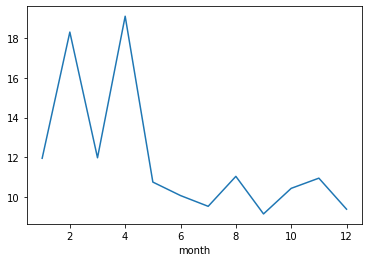

In [72]:
df.groupby('month').mean()['Value'].plot()

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Site                    183960 non-null  object        
 1   Value                   183960 non-null  float64       
 2   DateTime                183960 non-null  datetime64[ns]
 3   geometry                183960 non-null  object        
 4   Rd_len                  183960 non-null  float64       
 5   Gsp_area                183960 non-null  float64       
 6   pct_nRd_Gsp             183960 non-null  float64       
 7   nRd_Gsp_per_Rd_len      183960 non-null  float64       
 8   pct_nGsp_Rd             183960 non-null  float64       
 9   bp_mean                 183960 non-null  float64       
 10  tmp_mean                183960 non-null  float64       
 11  rh_mean                 183960 non-null  float64       
 12  log_Gsp_area            183960

In [75]:
high_period = df[df['month'].isin([1, 2, 3, 4])].drop(['geometry','hour','dayofweek','dayofmonth'],axis=1)
low_period = df[~df['month'].isin([1, 2, 3, 4])].drop(['geometry','hour','dayofweek','dayofmonth'],axis=1)

print('high period: '+str(high_period.shape)+'\nlow period: '+str(low_period.shape))

high period: (60480, 14)
low period: (123480, 14)


In [76]:
hp_X = high_period[var].values
hp_y = high_period['Value'].values

get_importance(reg, hp_X, hp_y, feature_names=var)

{'Rd_len': 0.05733,
 'log_Gsp_area': 0.20014,
 'pct_nRd_Gsp': 0.05409,
 'log_nRd_Gsp_per_Rd_len': 0.19169,
 'pct_nGsp_Rd': 0.00124,
 'bp_mean': 0.1036,
 'tmp_mean': 0.01219,
 'rh_mean': 0.00186}

In [107]:
get_cv_score(reg, hp_X, hp_y)

{'r2': 0.06261427365049085, 'variance': 3.906089452940173e-05}

In [108]:
reg.coef_.tolist() + [reg.intercept_]

[0.17682924161278382,
 -4.7138597226268555,
 -0.09416197820318661,
 5.335403898698772,
 -0.04581446903199904,
 0.22824010079214643,
 -0.19089626774204416,
 0.025193915179077715,
 -164.23360373280613]

In [109]:
lp_X = low_period[var].values
lp_y = low_period['Value'].values

get_importance(reg, lp_X, lp_y, feature_names=var)

{'Rd_len': 0.01941,
 'log_Gsp_area': 0.19139,
 'pct_nRd_Gsp': 0.13251,
 'log_nRd_Gsp_per_Rd_len': 0.06773,
 'pct_nGsp_Rd': 0.01443,
 'bp_mean': 0.05292,
 'tmp_mean': 0.00568,
 'rh_mean': 0.02377}

In [110]:
get_cv_score(reg, lp_X, lp_y)

{'r2': 0.04531013999755216, 'variance': 7.679723500130711e-05}

In [111]:
reg.coef_.tolist() + [reg.intercept_]

[-0.06477883610681165,
 2.9045030591594285,
 0.09368049866702144,
 -1.999571170705888,
 -0.10322265309086215,
 0.12175789535158825,
 -0.07656150063701962,
 0.05585286850974443,
 -149.76070408096325]

# Mean analysis

In [ ]:
hmean_df = df.groupby(['hour','Site']).mean()
hmean_df.info()

In [ ]:
hmean_df.drop(['bp_mean','tmp_mean','rh_mean','dayofweek','dayofmonth'],axis=1,inplace=True)

In [ ]:
hmean_df.hist()

In [ ]:
sns.heatmap(hmean_df[['Value']+var_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
def get_corr(df,iter_range,method='pearson',features=var_names,target='Value'):
    result=[]
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[features,target])
    result=np.asarray(result)
    return result

In [ ]:
def get_moran(df,iter_range,w=weight,target='Value'):
    result=[]
    for index in iter_range:
        result.append(Moran(df.loc[(index,),target].values,w).I)
    return result

In [ ]:
def get_reg_info(df,iter_range,features=var_names,target='Value',reg=LinearRegression()):
    result=[]
    for index in iter_range:
        x=df.loc[(index,),features].values
        #x=(x-np.mean(x,axis=0))/np.std(x,axis=0)
        
        y=df.loc[(index,),target].values
        #y=(y-np.mean(y,axis=0))/np.std(y,axis=0)
        
        reg.fit(x,y)
        coef=reg.coef_.tolist()
        coef.append(reg.score(x,y))
        result.append(coef)
    result=pd.DataFrame(result,columns=features+['score'])
    return result

In [ ]:
hmean_corr=get_corr(hmean_df,range(24))
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=var_names)
plt.show()

In [ ]:
hmean_corr_sp=get_corr(hmean_df,range(24),method='spearman')
sns.lineplot(data=hmean_corr_sp,legend=False)
plt.legend(labels=var_names)
plt.show()

In [ ]:
hmean_moran=get_moran(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_moran)

In [ ]:
hmean_reg=get_reg_info(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_reg['score'])

In [ ]:
# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [ ]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

In [ ]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

In [ ]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

In [ ]:
mmean_moran=get_moran(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_moran)

In [ ]:
mmean_reg=get_reg_info(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_reg['score'])

In [ ]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].groupby('Site').mean()
low=df[~df['month'].isin([1,2,3,4])].groupby('Site').mean()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

In [ ]:
sns.heatmap(high[['Value']+var_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
high_moran=Moran(high['Value'].values,weight)
round(high_moran.I,5)

In [ ]:
reg_high=LinearRegression()
y_high = high['Value'].values
x_high = high[var_names].values
reg_high.fit(x_high, y_high)
reg_high.score(x_high,y_high)

In [ ]:
prd_high = reg_high.predict(x_high)

r = stats.pearsonr(y_high, prd_high)[0]
r2 = r**2
t, p_value = stats.kendalltau(y_high, prd_high)
print('r2 (obs): ', round(r2, 5))
print('tau (obs): ', round(t, 5))

In [ ]:
cv_r2_high = []
cv_tau_high = []

for i in range(100):
    kf = KFold(n_splits=4, shuffle=True, random_state=i)
    cvprd_high = cross_val_predict(reg_high, x_high, y_high, cv=kf)  #predict using current random folds
    
    #correlations
    r = stats.pearsonr(y_high,cvprd_high)[0]
    t, p_value = stats.kendalltau(y_high, prd_high)
    
    #append to list
    cv_r2_high.append(r**2)
    cv_tau_high.append(t)

print('r2 (cv): ', round(np.mean(cv_r2_high), 5))
print('tau (cv): ', round(np.mean(cv_tau_high),5))
print('r2 variance (cv): ', 1.96 * np.var(cv_r2_high))
print('tau variance (cv): ', 1.96 * np.var(cv_tau_high))

In [ ]:
sns.heatmap(low[['Value']+var_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
low_moran=Moran(low['Value'].values,weight)
round(low_moran.I,5)

In [ ]:
reg_low = LinearRegression()
y_low = low['Value'].values
x_low = low[var_names].values
reg_low.fit(x_low, y_low)
prd_low = reg_low.predict(x_low)

r = low['Value'].corr(pd.Series(prd_low))
r2 = r**2
t = low['Value'].corr(pd.Series(prd_low), method='kendall')
print("r2 (cv): ", round(r2,3))   
print("tau (cv): ", round(t,3))

In [ ]:
sns.heatmap(all[['Value']+var_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
all=df.groupby('Site').mean()
all_moran=Moran(all['Value'].values,weight)
round(all_moran.I,5)

In [ ]:
y_all=(all.groupby('Site').mean()['Value'].values)
x_all=(all.groupby('Site').mean()[var_names].values)

reg.fit(x_all,y_all)
reg.score(x_all,y_all)